In [1]:
import torch
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from torch import nn, optim
from torch.utils.data import DataLoader
from jcopdl.callback import Callback, set_config
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mobilenet import CustomMobileNetv2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
bs = 32
crop_size = 224

train_transform = transforms.Compose([
	transforms.Resize(crop_size),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
	])

test_transform = transforms.Compose([
	transforms.Resize(crop_size),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
	])

train_set = datasets.ImageFolder("./train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

val_set = datasets.ImageFolder("./valid", transform=test_transform)
valloader = DataLoader(val_set, batch_size=bs, shuffle=True)

In [4]:
print(len(train_set), len(val_set))
label2cat = train_set.classes
print(label2cat, len(label2cat))

feature, target = next(iter(trainloader))
print(feature.shape)

5486 1828
['adding', 'none', 'stirring'] 3
torch.Size([32, 3, 224, 398])


In [5]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
	if mode == 'train':
		model.train()
	elif mode == 'val':
		model.eval()
  
	cost = correct = 0
	for feature, target in tqdm(dataloader, desc=mode.title()):
		feature, target = feature.to(device), target.to(device)
		output = model(feature)
		loss = criterion(output, target)

		if mode == 'train':
			loss.backward()
			optimizer.step()
			optimizer.zero_grad()
	
		cost += loss.item() * feature.shape[0]
		correct += (output.argmax(1) == target).sum().item()
	cost = cost/len(dataset)
	acc = correct/len(dataset)
	return cost, acc

In [6]:
config = set_config({
	'batch_size': bs,
	'crop_size': crop_size,
	'output_size': train_set.classes
})

In [7]:
model = CustomMobileNetv2(len(config.output_size)).to(device)
criterion = nn.CrossEntropyLoss()
callback = Callback(model, config, early_stop_patience=10, outdir='model')
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

/home/chakri/anaconda3/envs/hands/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/chakri/anaconda3/envs/hands/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train:   0%|          | 0/172 [00:00<?, ?it/s]

/home/chakri/Documents/Nymble Assignment/hands-segmentation-pytorch/test_videos/mobilenet.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(self.classifier(x))


Val:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6573 | Test_cost  = 0.8313 | Train_score = 0.8934 | Test_score = 0.7117 |


Train:   0%|          | 0/172 [00:00<?, ?it/s]

Val:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6006 | Test_cost  = 0.7901 | Train_score = 0.9504 | Test_score = 0.7549 |


Train:   0%|          | 0/172 [00:00<?, ?it/s]

Val:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.5963 | Test_cost  = 0.8302 | Train_score = 0.9544 | Test_score = 0.7128 |
==> EarlyStop patience =  1 | Best test_score: 0.7549


Train:   0%|          | 0/172 [00:00<?, ?it/s]

Val:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5847 | Test_cost  = 0.8159 | Train_score = 0.9657 | Test_score = 0.7303 |
==> EarlyStop patience =  2 | Best test_score: 0.7549
==> Execute Early Stopping at epoch: 4 | Best test_score: 0.7549
==> Best model is saved at model


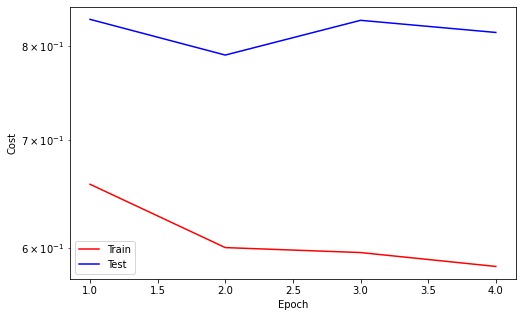

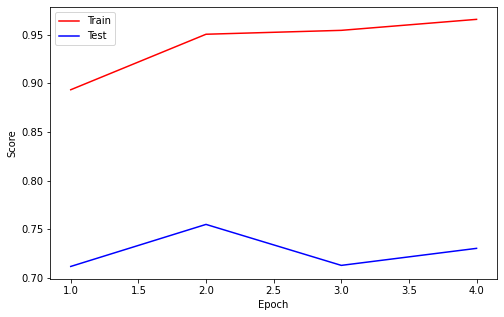

In [8]:
while True:
	train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
	with torch.no_grad():
		test_cost, test_score = loop_fn('val', val_set, valloader, model, criterion, optimizer, device)

	# Logging
	callback.log(train_cost, test_cost, train_score, test_score)

	# Checkpoint
	callback.save_checkpoint()

	# Runtime Plotting
	callback.cost_runtime_plotting()
	callback.score_runtime_plotting()

	# Early Stopping
	if callback.early_stopping(model, monitor='test_score'):
		callback.plot_cost()
		callback.plot_score()
		break

torch.Size([36, 3, 224, 398])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

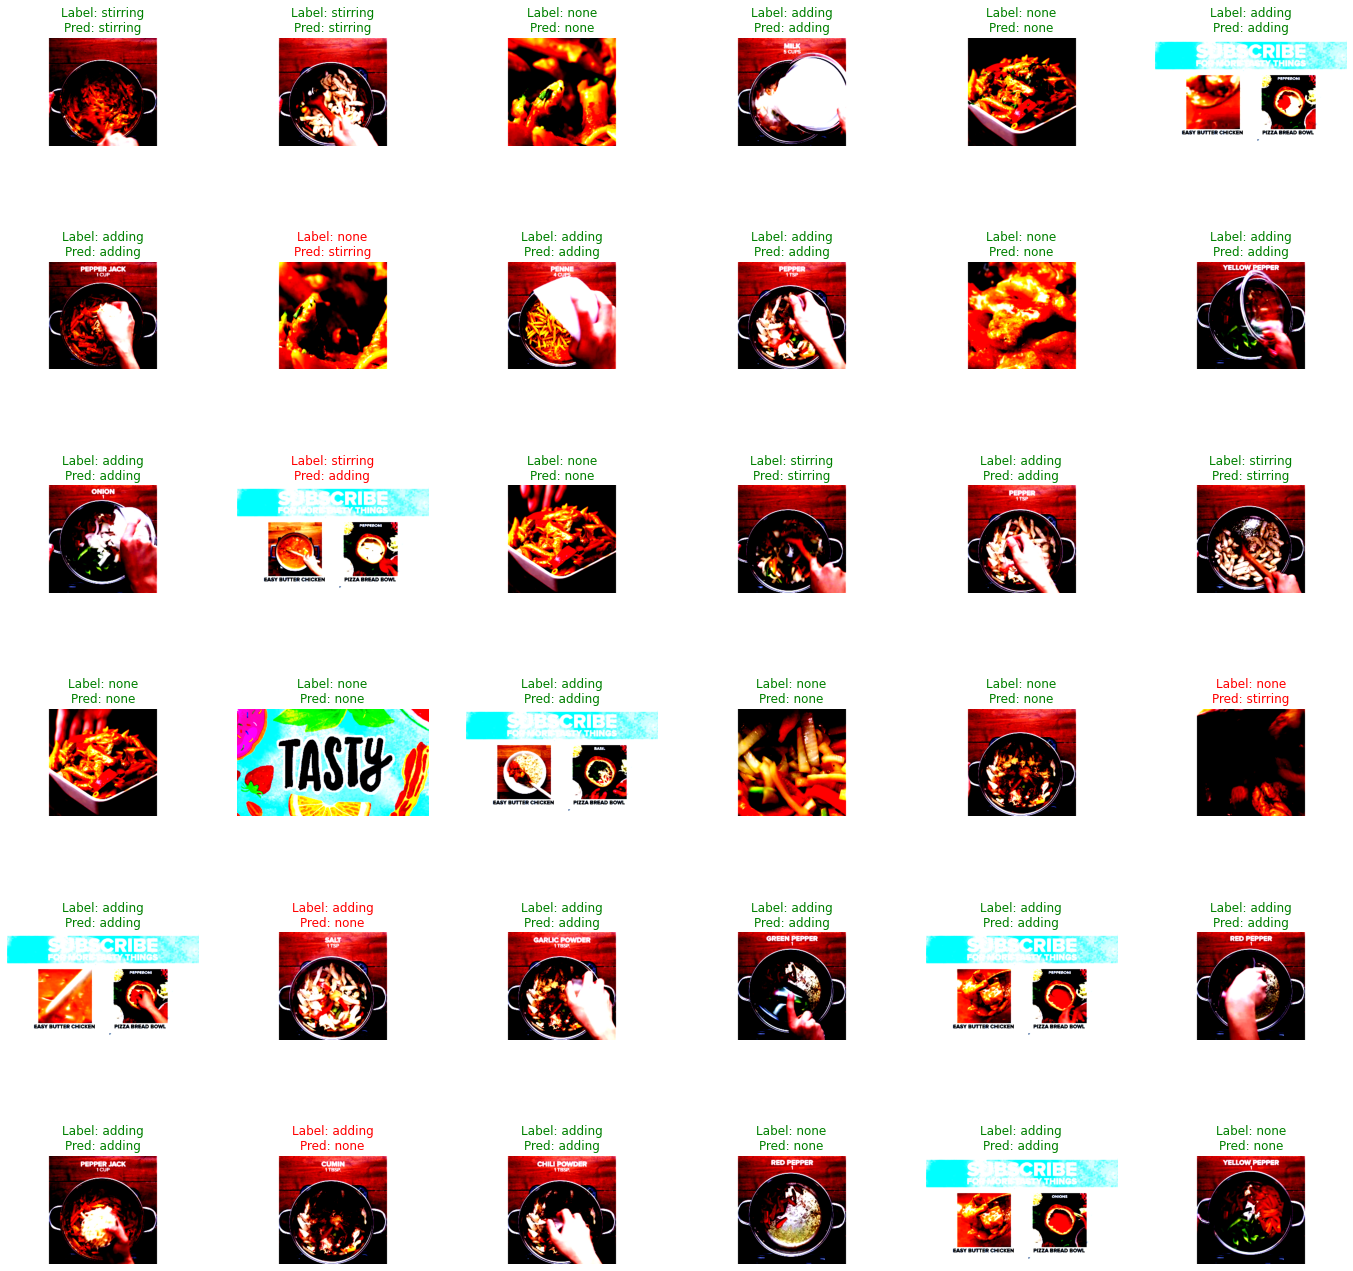

In [9]:
### Predict one batch to populate the plot
test_set = datasets.ImageFolder("./test", transform=test_transform)
testloader = DataLoader(test_set, shuffle=True, batch_size=36)

for feature, target in testloader:
    print(feature.shape)
    feature, target = feature.to(device), target.to(device)
    with torch.no_grad():
        model.eval()
        output = model(feature)
        preds = output.argmax(1)
        break

fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color":'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
    ax.axis("off")

torch.Size([36, 3, 224, 398])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

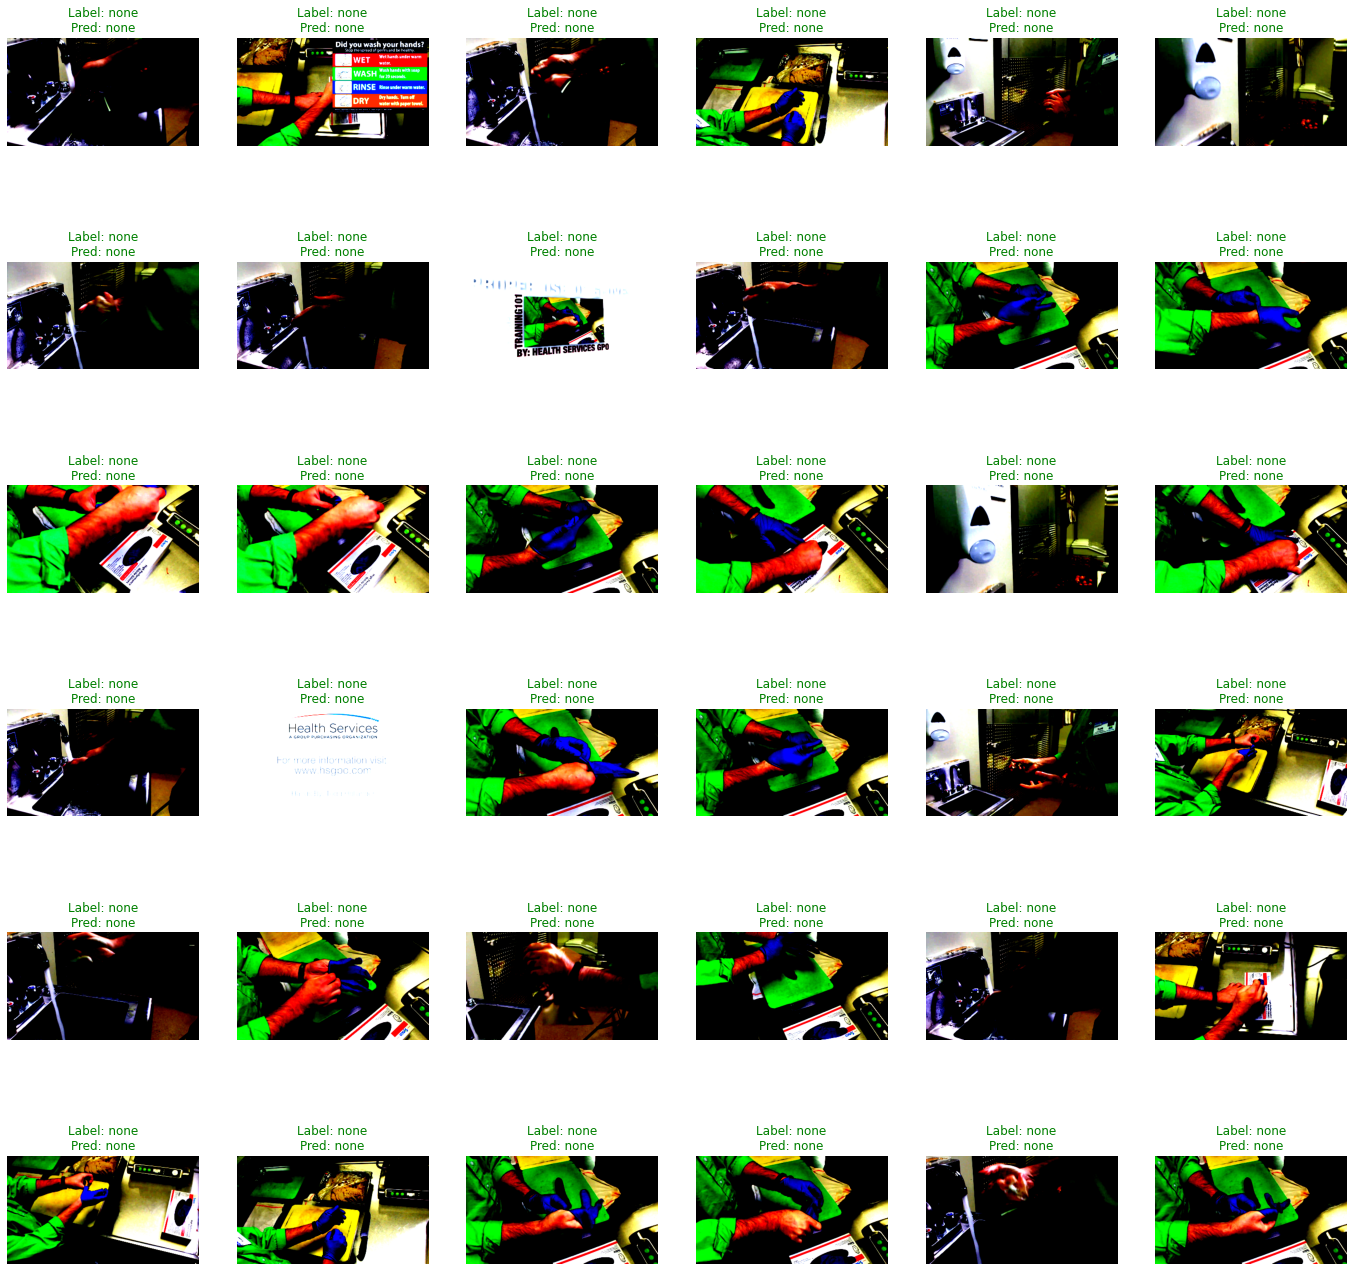

In [11]:
test_set = datasets.ImageFolder("./testg", transform=test_transform)
testloader = DataLoader(test_set, shuffle=True, batch_size=36)

for feature, target in testloader:
    print(feature.shape)
    feature, target = feature.to(device), target.to(device)
    with torch.no_grad():
        model.eval()
        output = model(feature)
        preds = output.argmax(1)
        break

fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color":'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
    ax.axis("off")

0.9986192613047981


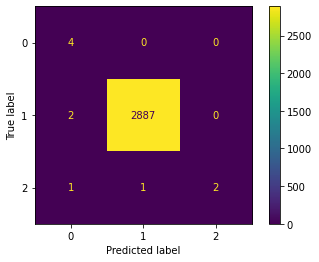

In [12]:
### Test accuracy of kitchen training video
### Due to the primitive nature of accuracy calculation, we're using batch size of 1
test_set = datasets.ImageFolder("./testg", transform=test_transform)
testloader = DataLoader(test_set, shuffle=True)

accuracy = []
targets = []
predictions = []
for feature, target in testloader:
	feature, target = feature.to(device), target.to(device)
	with torch.no_grad():
		model.eval()
		output = model(feature)
		preds = output.argmax(1)
		if(target == preds):
			acc = 1
		else: 
			acc = 0
		accuracy.append(acc)
		targets.append(target.cpu().detach().numpy())
		predictions.append(preds.cpu().detach().numpy())
accuracy = np.array(accuracy)
print(accuracy.mean())

predNumpy = [i[0] for i in predictions]
cm = confusion_matrix(targets, predNumpy)
ConfusionMatrixDisplay(cm).plot()

/home/chakri/Documents/Nymble Assignment/hands-segmentation-pytorch/test_videos/mobilenet.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(self.classifier(x))


0.8400918133129304


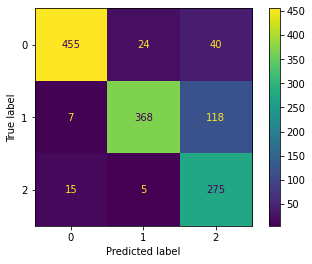

In [13]:
### Test accuracy of the cooking video
### Due to the primitive nature of accuracy calculation, we're using batch size of 1
test_set = datasets.ImageFolder("./test", transform=test_transform)
testloader = DataLoader(test_set, shuffle=True)

accuracy = []
targets = []
predictions = []
for feature, target in testloader:
	feature, target = feature.to(device), target.to(device)
	with torch.no_grad():
		model.eval()
		output = model(feature)
		preds = output.argmax(1)
		if(target == preds):
			acc = 1
		else: 
			acc = 0
		accuracy.append(acc)
		targets.append(target.cpu().detach().numpy())
		predictions.append(preds.cpu().detach().numpy())
accuracy = np.array(accuracy)
print(accuracy.mean())

predNumpy = [i[0] for i in predictions]
cm = confusion_matrix(targets, predNumpy)
ConfusionMatrixDisplay(cm).plot()